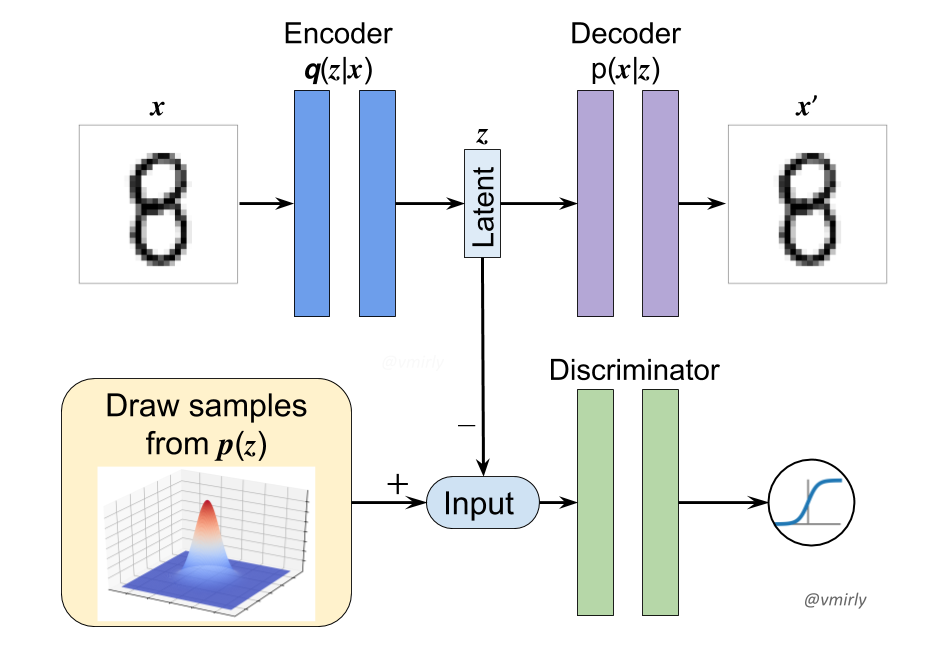

In [1]:
from IPython.display import Image
Image("figs/adversarial-autoencoder.png")

Ref: **Adversarial Autoencoders**, by A Makhzani, J Shlens, N Jaitly, I Goodfellow, and B Frey [Link to Publication:](https://arxiv.org/abs/1511.05644)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [3]:
## Settings:

# CUDA Device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
num_epochs = 10
batch_size = 128
learning_rate = 0.001

# Model Parameters
num_features = 784
num_hidden_1 = 100
num_latent = 15

Device: cuda:0


In [4]:
## MNIST Data Loader

train_dataset = datasets.MNIST(root='./mnist/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_dataset = datasets.MNIST(root='./mnist/', 
                              train=False, 
                              transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
images, labels = next(iter(train_loader))
print('Images dimension:', images.shape)
print('Labels dimension:', labels.shape)


Processing...
Done!
Images dimension: torch.Size([128, 1, 28, 28])
Labels dimension: torch.Size([128])


# Class for Adversarial Autoencoder

In [5]:
###### MODEL: Generator ######

class AdversarialAutoencoder(nn.Module):
    """The generator network (G)"""
    def __init__(self, num_features, num_hidden_1, num_latent):
        super(AdversarialAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(num_features, num_hidden_1),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden_1, num_latent))
        self.decoder = nn.Sequential(
            nn.Linear(num_latent, num_hidden_1),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden_1, num_features),
            nn.Sigmoid())

    def forward(self, x, from_latent=False, return_mode='both'):
        if not from_latent:
            z = self.encoder(x)
            if return_mode == 'latent':
                return z
        else:
            z = x
            
        return z, self.decoder(z)


In [6]:
###### MODEL: Discriminator ######

class Discriminator(nn.Module):
    """Discriminator network (D)"""
    def __init__(self, num_ae_latent=20, num_hidden_1=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(num_ae_latent, num_hidden_1),
            nn.ReLU(inplace=True),
            nn.Linear(num_hidden_1, 1))
        
    def forward(self, x):
        return self.main(x)

    
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2"""
    weight = torch.ones(y.size()).to(device)
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    return torch.mean((dydx_l2norm-1)**2)

def reset_grads():
    """A helper function to reset gradient buffers"""
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()


# Training

In [7]:
lambda_gp = 10.0
lambda_rec = 1.0
lambda_src = 2.0
n_critics = 1
num_latent = 20

torch.manual_seed(random_seed)
G = AdversarialAutoencoder(num_features, num_hidden_1, num_latent)
G = G.to(device)

D = Discriminator(num_latent, num_hidden_1)
D = D.to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)


#======================================================= #
#                       Training                         #
#======================================================= #

for epoch in range(10): #num_epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
        
        images = images.to(device).view(-1, 28*28)

        # ======================================================= #
        #                 1. Train the discriminator              #
        # ======================================================= #
        z_real = torch.randn(images.size(0), num_latent).to(device)
        out_real = D(z_real)
        d_loss_real = -torch.mean(out_real)
        
        z_fake = G(images, return_mode='latent')
        out_fake = D(z_fake)
        d_loss_fake = torch.mean(out_fake)
        
        ## >> gradient-penalty
        alpha = torch.rand(z_real.size(0), 1).to(device)
        z_fake_hat = (alpha * z_real.detach() + (1 - alpha) * z_fake.detach()).requires_grad_(True)
        out_fake_hat = D(z_fake_hat)
        d_loss_gp = gradient_penalty(out_fake_hat, z_fake_hat)
        
        d_loss = (lambda_src*(d_loss_real + d_loss_fake) + 
                  lambda_gp*d_loss_gp)
        
        reset_grads()
        d_loss.backward()
        d_optimizer.step()
        
        # ======================================================= #
        #                2. Train the generator (AE)              #
        # ======================================================= #
        if batch_idx % n_critics == 0:
            z_fake, x_rec = G(images, return_mode='both')
            out_fake = D(z_fake)
            g_loss_fake = -torch.mean(out_fake)

            g_loss_rec = F.binary_cross_entropy(x_rec, images, reduction='sum') / images.size(0)

            g_loss = lambda_src*g_loss_fake + lambda_rec*g_loss_rec

            reset_grads()
            g_loss.backward()
            g_optimizer.step()
                
        if not batch_idx % 200:
            print ('Epoch: {:03d}/{:03d} | Batch {:03d}/{:03d} |'.format(
                   epoch+1, num_epochs, batch_idx, len(train_dataset)//batch_size), end=' ')
            print('G-loss: {:.3f} {:.3f} D-loss: {:.3f} {:.3f} {:.3f}'.format(
                   g_loss_fake, g_loss_rec, d_loss_real, d_loss_fake, d_loss_gp))

Epoch: 001/010 | Batch 000/468 | G-loss: -0.011 545.940 D-loss: -0.035 0.012 0.632
Epoch: 001/010 | Batch 200/468 | G-loss: 4.694 162.571 D-loss: -0.360 -4.569 0.146
Epoch: 001/010 | Batch 400/468 | G-loss: 4.317 130.497 D-loss: 1.774 -4.016 0.033
Epoch: 002/010 | Batch 000/468 | G-loss: 5.244 129.342 D-loss: 2.796 -5.057 0.035
Epoch: 002/010 | Batch 200/468 | G-loss: 5.220 117.617 D-loss: 3.467 -5.204 0.038
Epoch: 002/010 | Batch 400/468 | G-loss: 4.850 104.378 D-loss: 3.718 -4.840 0.033
Epoch: 003/010 | Batch 000/468 | G-loss: 4.742 107.837 D-loss: 3.668 -4.713 0.020
Epoch: 003/010 | Batch 200/468 | G-loss: 4.715 100.442 D-loss: 3.636 -4.680 0.013
Epoch: 003/010 | Batch 400/468 | G-loss: 4.598 98.854 D-loss: 3.563 -4.593 0.020
Epoch: 004/010 | Batch 000/468 | G-loss: 4.288 91.307 D-loss: 3.708 -4.284 0.015
Epoch: 004/010 | Batch 200/468 | G-loss: 3.782 91.314 D-loss: 3.535 -3.763 0.007
Epoch: 004/010 | Batch 400/468 | G-loss: 3.656 93.249 D-loss: 3.376 -3.643 0.006
Epoch: 005/010 | B

# Evaluation

## Part-1: Evaluation based on input

torch.Size([128, 1, 28, 28])
torch.Size([20, 1, 28, 28])


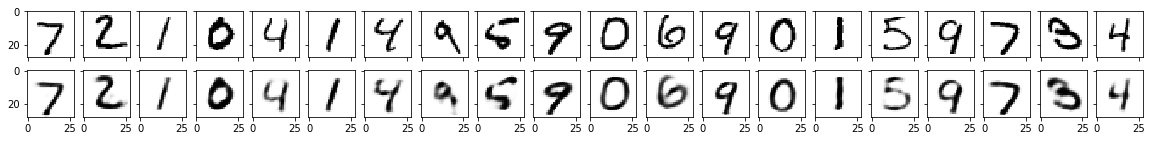

In [12]:

%matplotlib inline
import matplotlib.pyplot as plt


n_images = 20
image_width, image_height = 28, 28

images, labels = next(iter(test_loader))
print(images.shape)
fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2))
input_images = images[:n_images]
print(input_images.shape)
outputs = G(input_images.to(device).view(-1, image_width*image_height))
output_images = outputs[1].cpu()

for i in range(n_images):
    for ax, img in zip(axes, [input_images, output_images]):
        ax[i].imshow(img[i].detach().reshape((image_width, image_width)), cmap='binary')

## Part-2: Evalaution based on latent space sampled from $p(z)$

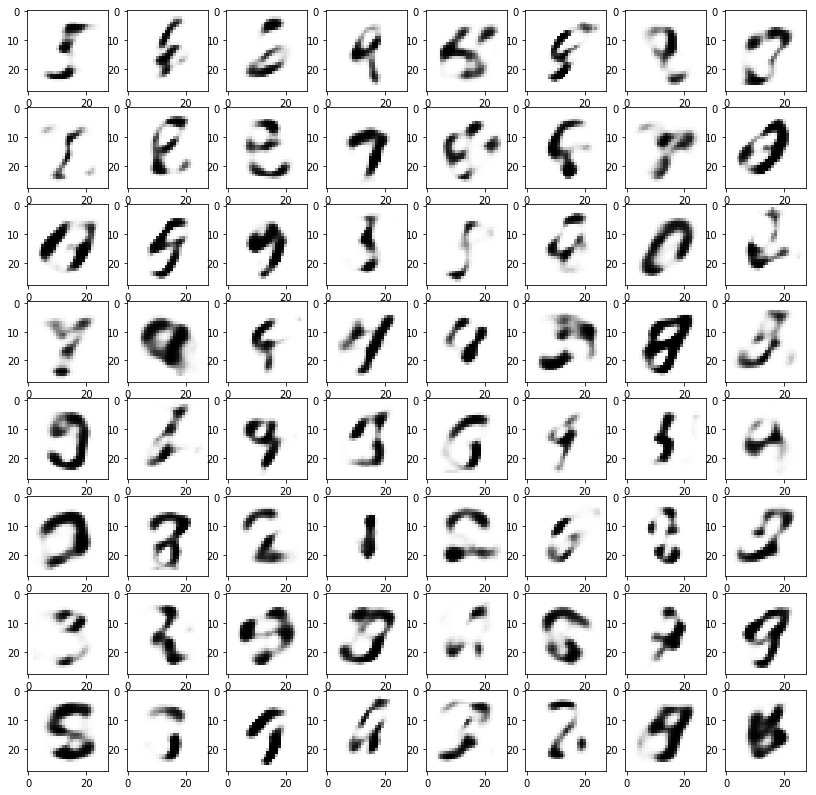

In [13]:
n_images = 64
latent = torch.randn(n_images, num_latent).to(device)

outputs = G(latent, from_latent=True)

fig = plt.figure(figsize=(14, 14))
for i in range(n_images):
    ax = fig.add_subplot(8, 8, i+1)
    ax.imshow(outputs[1][i].detach().reshape((image_width, image_width)), cmap='binary')